In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, multiprocessing as mp
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange
from ecology_functions import *

In [2]:
T = 100
I = 5  # number of locations
J = 3  # number of species
K = 2   # number of latent factors

In [3]:
lmbda = npr.randn(J,K)
alpha = npr.randn(J)
c = 0
phi = 0.5
logsigmasq = 0
x_0 = npr.randn(I,K)

theta = [alpha, lmbda, c, phi, logsigmasq]
Y, X = simulate_data(x_0, T, J, theta)

In [4]:
n = 1000
logNC, est_grad = bootstrap_PF_grad(x_0, n, theta, Y)

In [5]:
est_grad

[array([565.71433293, 277.83525583, -69.50875034]),
 array([[ 45.06703386, -20.22768086],
        [-48.51357358, -51.79767372],
        [-30.95149896,   6.78830026]]),
 1.3856789778715974,
 -922.9987461979838,
 456.0082615167247]

In [11]:
n_mcmc = 100
n_particles = 100
theta_mala, acc_probs_mala = pMCMC_mala(x_0, Y, theta, n_particles, n_mcmc, tau=1e-5)

/home/postdoc/dsen/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)
100%|██████████| 100/100 [00:17<00:00,  6.05it/s]

2.0 % acceptance rate


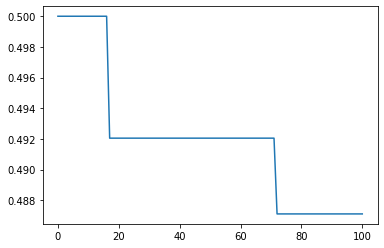

In [13]:
plt.plot(theta_mala[3])

In [6]:
import torch 

In [100]:
lmbda = torch.randn(J,K, requires_grad=True)
alpha = torch.randn(J,1, requires_grad=True)
c = torch.tensor(0., requires_grad=True)
phi = torch.tensor(0.5, requires_grad=True)
logsigmasq = torch.tensor(0., requires_grad=True)
x_0 = torch.randn(I,K)

theta = [alpha, lmbda, c, phi, logsigmasq]
X = torch.randn(T,I,K)
Y = torch.bernoulli(0.5*torch.ones((T,I,J)))

In [113]:
n_particles = 100
particles = torch.randn(I,K,n_particles)
propagated_particles = torch.randn(I,K,n_particles)

In [135]:
def update_grad(y, theta, propagated_particles, particles, weights) :
    alpha, lmbda, c, phi, logsigmasq = theta[:]
    b = torch.add(alpha, torch.matmul(lmbda,particles))
    ll1 = -1/(2*torch.exp(logsigmasq))*torch.sum(weights*torch.sum((propagated_particles - c - phi*particles)**2, [0,1]))
    ll2 = torch.sum(weights*torch.sum(b.transpose(0,2)*((y-1).transpose(0,1)), [1,2]))
    ll = ll1 + ll2
    ll.backward()

In [136]:
for t in range(T) :
    weights = torch.rand(n_particles)
    weights = weights/torch.sum(weights)
    update_grad(Y[t], theta, particles_new, particles_old, weights)

In [137]:
alpha.grad

tensor([[-51456.],
        [-50049.],
        [-49647.]])